In [1]:
import gensim
from gensim.models import Word2Vec
import pandas as pd
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset and specify column names
messages = pd.read_csv('spam.csv', names=['label', 'message', 'unnamed1', 'unnamed2', 'unnamed3'])

In [4]:
# Remove unnecessary columns
messages = messages.drop(['unnamed1', 'unnamed2', 'unnamed3'], axis=1)
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
# Initialize lemmatizer and preprocess the messages
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(messages)):
    # Clean the message by removing non-alphabetic characters and converting to lowercase
    review = re.sub('[^a-zA-Z]', ' ', messages['message'][i])
    review = review.lower()
    review = review.split()
    # Apply lemmatization to each word
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [6]:
# Tokenize sentences and prepare a list of words
words = []
for sent in corpus:
    sent_tokens = sent_tokenize(sent)
    for sent in sent_tokens:
        words.append(simple_preprocess(sent))

In [7]:
# Train a Word2Vec model on the tokenized words
model = gensim.models.Word2Vec(words)
print(f"Vocabulary Size: {len(model.wv.index_to_key)}")
print(f"Corpus Count: {model.corpus_count}")
print(f"Training Epochs: {model.epochs}")

Vocabulary Size: 1709
Corpus Count: 5569
Training Epochs: 5


In [8]:
# Function to compute average Word2Vec embedding for a document
def avg_word2vec(doc):
    vectors = [model.wv[word] for word in doc if word in model.wv.index_to_key]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [9]:
# Filter out empty tokens
words = [w for w in words if len(w) > 0]

In [10]:
# Compute Word2Vec embeddings for all documents
X = []
for i in tqdm(range(len(words))):
    vector = avg_word2vec(words[i])
    if vector is not None:
        X.append(vector)

  0%|          | 0/5567 [00:00<?, ?it/s]

100%|██████████| 5567/5567 [00:04<00:00, 1125.51it/s]


In [11]:
X_new = np.array(X)
print(f"Shape of X_new: {X_new.shape}")

Shape of X_new: (5567, 100)


In [12]:
# Prepare the target variable
y = messages[list(map(lambda x: len(x) > 0, corpus))]
y = pd.get_dummies(y['label'])
y = y.iloc[:, 0].values

In [13]:
# Ensure feature and target arrays have the same length
if len(X) != len(y):
    min_length = min(len(X), len(y))
    X = X[:min_length]
    y = y[:min_length]

In [14]:
# Create a DataFrame from feature vectors and add the target column
df = pd.DataFrame(X_new.tolist())
df['Output'] = y
df.dropna(inplace=True)

In [15]:
# Check for and handle missing values
print(f"Missing values in dataset:\n{df.isnull().sum()}")

Missing values in dataset:
0         0
1         0
2         0
3         0
4         0
         ..
96        0
97        0
98        0
99        0
Output    0
Length: 101, dtype: int64


In [16]:
# Separate features and target variable
X = df.drop('Output', axis=1)
y = df['Output']

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [18]:
# Initialize and train a Random Forest Classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
# Evaluate the model on the test set
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9299820466786356
              precision    recall  f1-score   support

       False       0.77      0.57      0.65       130
        True       0.94      0.98      0.96       984

    accuracy                           0.93      1114
   macro avg       0.86      0.77      0.81      1114
weighted avg       0.92      0.93      0.93      1114



C:\Users\pandey\AppData\Local\Temp\ipykernel_7720\850370659.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


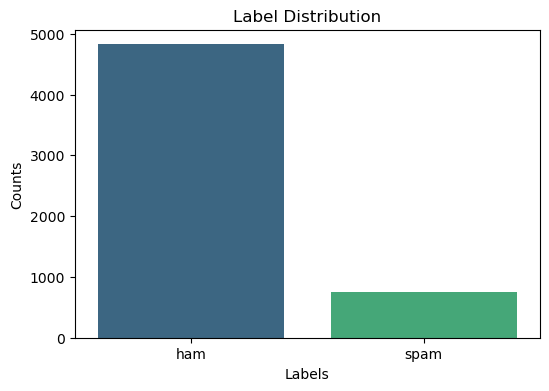

In [20]:
# Visualize the label distribution
label_counts = messages['label'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()